In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

from tqdm import tqdm

x_dim = 784
z_dim = 2

batch_size = 128
epochs = 10
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [2]:
root = './data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda x: x.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=True, transform=transform, download=True),
    shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=False, transform=transform),
    shuffle=False, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [3]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler
from pixyz.utils import print_latex 

In [4]:
from torch import optim

from pixyz.models.model import Model
from pixyz.utils import tolist


class VAE(Model):
    """
    Variational Autoencoder.
    In VAE class, reconstruction loss on given distributions (encoder and decoder) is set as the default loss class.
    However, if you want to add additional terms, e.g., the KL divergence between encoder and prior,
    you need to set them to the `regularizer` argument, which defaults to None.
    References
    ----------
    [Kingma+ 2013] Auto-Encoding Variational Bayes
    """
    def __init__(self, encoder, decoder,
                 other_distributions=[],
                 regularizer=None,
                 optimizer=optim.Adam,
                 optimizer_params={},
                 clip_grad_norm=None,
                 clip_grad_value=None):
        """
        Parameters
        ----------
        encoder : torch.distributions.Distribution
            Encoder distribution.
        decoder : torch.distributions.Distribution
            Decoder distribution.
        regularizer : torch.losses.Loss, defaults to None
            If you want to add additional terms to the loss, set them to this argument.
        optimizer : torch.optim
            Optimization algorithm.
        optimizer_params : dict
            Parameters of optimizer
        clip_grad_norm : float or int
            Maximum allowed norm of the gradients.
        clip_grad_value : float or int
            Maximum allowed value of the gradients.
        """

        # set distributions (for training)
        distributions = [encoder, decoder] + tolist(other_distributions)

        # set losses
        reconstruction = -decoder.log_prob().expectation(encoder)
        loss = (reconstruction + regularizer).mean()

        super().__init__(loss, test_loss=loss,
                         distributions=distributions,
                         optimizer=optimizer, optimizer_params=optimizer_params,
                         clip_grad_norm=clip_grad_norm, clip_grad_value=clip_grad_value)

    def train(self, train_x_dict={}, **kwargs):
        return super().train(train_x_dict, **kwargs)

    def test(self, test_x_dict={}, **kwargs):
        return super().test(test_x_dict, **kwargs)

In [5]:



# inference model q(z|x)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["x"], var=["z"], name="q")

        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

    
# generative model p(x|z)    
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["z"], var=["x"], name="p")

        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}
    
p = Generator().to(device)
q = Inference().to(device)

prior = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
               var=["z"], features_shape=[z_dim], name="p_{prior}").to(device)

In [6]:
kl = KullbackLeibler(q, prior)
print(kl)
print_latex(kl)

D_{KL} \left[q(z|x)||p_{prior}(z) \right]


<IPython.core.display.Math object>

In [7]:
model = VAE(q, p, regularizer=kl, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)
print_latex(model)

Distributions (for training): 
  q(z|x), p(x|z) 
Loss function: 
  mean \left(D_{KL} \left[q(z|x)||p_{prior}(z) \right] - \mathbb{E}_{q(z|x)} \left[\log p(x|z) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


<IPython.core.display.Math object>

In [8]:
def train(epoch):
    train_loss = 0
    for x, _ in tqdm(train_loader):
        x = x.to(device)
        loss = model.train({"x": x})
        train_loss += loss
 
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [9]:
def test(epoch):
    test_loss = 0
    for x, _ in test_loader:
        x = x.to(device)
        loss = model.test({"x": x})
        test_loss += loss

    test_loss = test_loss * test_loader.batch_size / len(test_loader.dataset)
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

In [10]:

def plot_reconstrunction(x):
    with torch.no_grad():
        z = q.sample({"x": x}, return_all=False)
        recon_batch = p.sample_mean(z).view(-1, 1, 28, 28)
    
        comparison = torch.cat([x.view(-1, 1, 28, 28), recon_batch]).cpu()
        return comparison


def plot_image_from_latent(z_sample):
    with torch.no_grad():
        sample = p.sample_mean({"z": z_sample}).view(-1, 1, 28, 28).cpu()
        return sample

In [11]:

writer = SummaryWriter()

z_sample = 0.5 * torch.randn(64, z_dim).to(device)
_x, _ = iter(test_loader).next()
_x = _x.to(device)

for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
    recon = plot_reconstrunction(_x[:8])
    sample = plot_image_from_latent(z_sample)

    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)      
    
    writer.add_images('Image_from_latent', sample, epoch)
    writer.add_images('Image_reconstrunction', recon, epoch)
    
writer.close()

100%|██████████| 469/469 [00:04<00:00, 94.45it/s]

Epoch: 1 Train loss: 179.3369



  0%|          | 0/469 [00:00<?, ?it/s]

Test loss: 162.2251


100%|██████████| 469/469 [00:04<00:00, 94.32it/s]

Epoch: 2 Train loss: 157.4221



  0%|          | 0/469 [00:00<?, ?it/s]

Test loss: 156.3061


100%|██████████| 469/469 [00:05<00:00, 91.96it/s]

Epoch: 3 Train loss: 152.8125



  0%|          | 0/469 [00:00<?, ?it/s]

Test loss: 152.9466


100%|██████████| 469/469 [00:05<00:00, 92.66it/s]

Epoch: 4 Train loss: 149.9449



  0%|          | 0/469 [00:00<?, ?it/s]

Test loss: 150.7823


100%|██████████| 469/469 [00:05<00:00, 89.74it/s]

Epoch: 5 Train loss: 148.0925



  0%|          | 0/469 [00:00<?, ?it/s]

Test loss: 149.1488


100%|██████████| 469/469 [00:05<00:00, 92.05it/s]


Epoch: 6 Train loss: 146.8933


  0%|          | 0/469 [00:00<?, ?it/s]

Test loss: 148.3994


100%|██████████| 469/469 [00:05<00:00, 92.42it/s]

Epoch: 7 Train loss: 145.8127



  0%|          | 0/469 [00:00<?, ?it/s]

Test loss: 147.6726


100%|██████████| 469/469 [00:05<00:00, 90.56it/s]

Epoch: 8 Train loss: 144.9682



  0%|          | 0/469 [00:00<?, ?it/s]

Test loss: 147.0880


100%|██████████| 469/469 [00:05<00:00, 88.98it/s]

Epoch: 9 Train loss: 144.2025



  0%|          | 0/469 [00:00<?, ?it/s]

Test loss: 145.7219


100%|██████████| 469/469 [00:05<00:00, 91.67it/s]

Epoch: 10 Train loss: 143.5316


Test loss: 145.6588


In [12]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [13]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

再構成:


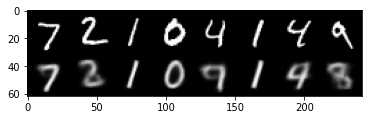

事前分布からのサンプル:


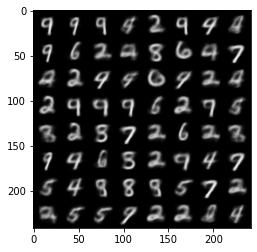

In [14]:
print('再構成:')
recon = plot_reconstrunction(_x[:8])
imshow(torchvision.utils.make_grid(recon))

print('事前分布からのサンプル:')
sample = plot_image_from_latent(z_sample)
imshow(torchvision.utils.make_grid(sample))

In [15]:
def interact_plot(a, b):
    z_sample = 0.5 * torch.tensor([a, b]).to(device)
    sample = plot_image_from_latent(z_sample)
    imshow(torchvision.utils.make_grid(sample))
    

In [16]:
from ipywidgets import interact
interact(interact_plot, a=(-1,1, 0.1), b=(-1,1, 0.1))

interactive(children=(FloatSlider(value=0.0, description='a', max=1.0, min=-1.0), FloatSlider(value=0.0, descr…

<function __main__.interact_plot(a, b)>